In [87]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SequentialSampler
import pickle

import models.modeling as original
import models.modeling_bitlinear as binary


In [2]:
os.makedirs("attention_data", exist_ok=True)
#if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
#    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
#if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
#    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

#imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [75]:
# Download CIFAR-10 (if it doesn't exist) and create the test loader
batch_size = 4

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

testset = datasets.CIFAR10(root="attention_data", train=False, download=True, transform=transform_test)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [3]:
# Get labels
with open("attention_data/cifar-10-batches-py/batches.meta", 'rb') as labels_names:
    cifar10_labels = pickle.load(labels_names, encoding='bytes')

print(cifar10_labels)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


In [5]:
# Base model used as starting point
#urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k%2Bimagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16.npz")

## Evluating Test Accuracy of Trained Models

+ Model weights and training logs can be found [here](https://drive.google.com/drive/u/2/folders/1o6YwUx-lfn0kfxaYC3NJm3I4hEBYuy2n)

In [4]:
# select device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
def eval_model(model):
    model.eval()
    global_acc = 0
    for idx, batch in enumerate(test_dataloader):
        with torch.no_grad():
            images, labels = batch
            images = images.to(device)
            
            logits, _ = model(images)

            for idx, image_logits in enumerate(logits):
                probs = torch.nn.Softmax(dim=-1)(image_logits)
                sorted_probs = torch.argsort(probs, dim=-1, descending=True)
                if cifar10_labels[b'label_names'][sorted_probs[0].item()] == cifar10_labels[b'label_names'][labels[idx].item()]:
                    global_acc += 1
                    

    global_acc /= len(testset)
    print(global_acc)

## Classification Accuracy on CIFAR-10

In [5]:
# Baseline finetune run
checkpoint_path = "output/baseline_checkpoint.bin"
config = original.CONFIGS["ViT-B_16"]
baseline_model = original.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
baseline_model.load_state_dict(checkpoint)

baseline_model

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

In [9]:
# CIFAR-10 Accuracy for baseline model
eval_model(baseline_model)

0.9904


In [11]:
# Binarized Run 10,000 iterations
checkpoint_path = "output/config1_checkpoint.bin"
config = binary.CONFIGS["ViT-B_16"]
bit_model1 = binary.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
bit_model1.load_state_dict(checkpoint)

print(bit_model1)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): BitLinear(in_features=768, out_features=3072, bias=True)
            (fc2): BitLinear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): BitLinear(in_features=768, out_features=768, bias=True)
            (key): BitLinear(in_features=768, out_features=768, bias=True)
            (value): BitLinear(in_features=768, out_features=768, bias=True)
            (out): BitLinear(in_features=768, out_feat

In [12]:
# CIFAR-10 Accuracy for Binarized Run 10,000 iterations
eval_model(bit_model1)

0.3636


In [11]:
# Binarized Run 50,000 iterations
checkpoint_path = "output/config2_checkpoint.bin"
config = binary.CONFIGS["ViT-B_16"]
bit_model2 = binary.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=False).to(device)
checkpoint = torch.load(checkpoint_path)
bit_model2.load_state_dict(checkpoint)

# CIFAR-10 Accuracy for Binarized Run 50,000 iterations
eval_model(bit_model2)

0.4362


## Visualize Attention Map

In [220]:
def show_attention_map(model, img):
    x = transform_test(img)
    x = x.unsqueeze(0)
    x = x.to(device)

    model.eval()
    logits, att_mat = model(x)

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1), device=device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size(), device=device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
    mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
    result = (mask * img).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(img)
    _ = ax2.imshow(result)

    probs = torch.nn.Softmax(dim=-1)(logits)
    top5 = torch.argsort(probs, dim=-1, descending=True)

    print("Prediction Label and Attention Map!\n")
    labels = cifar10_labels[b'label_names']
    for idx in top5[0, :5]:
        print(f'{probs[0, idx.item()]:.5f} : {labels[idx.item()]}')

In [221]:
dataset = datasets.CIFAR10(root="attention_data", train=False, download=True, transform=None)

Files already downloaded and verified


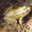

In [215]:
# img, label = dataset[64]
img, label = dataset[19]
img

In [216]:
img = Image.open('Frog-tree.jpg')

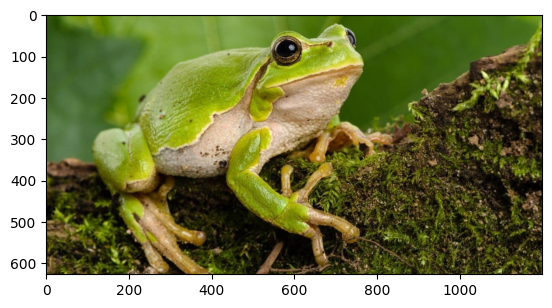

In [217]:
plt.imshow(img)

In [218]:
# Baseline finetune run
checkpoint_path = "output/baseline_checkpoint.bin"
config = original.CONFIGS["ViT-B_16"]

# Need to set vis=True to get attn map
baseline_model = original.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=True).to(device)
checkpoint = torch.load(checkpoint_path)
baseline_model.load_state_dict(checkpoint)

<All keys matched successfully>

Prediction Label and Attention Map!

0.99998 : b'frog'
0.00001 : b'bird'
0.00000 : b'dog'
0.00000 : b'airplane'
0.00000 : b'cat'


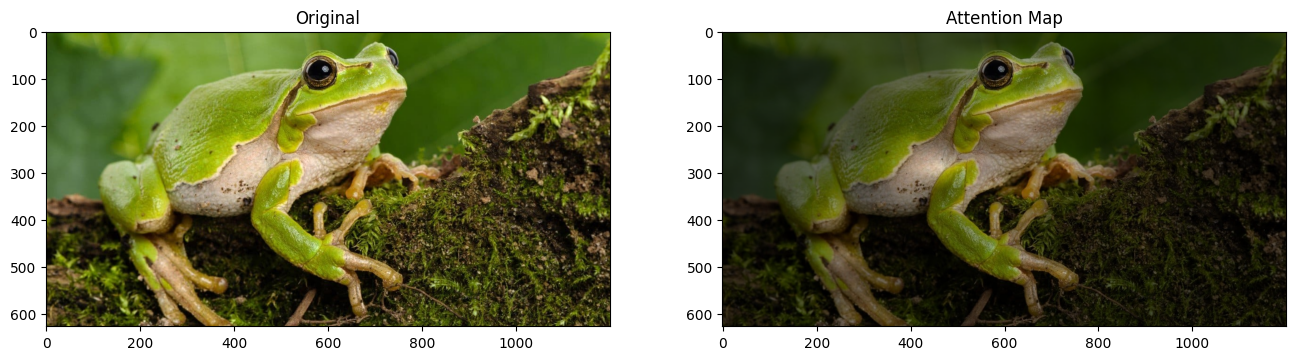

In [222]:
show_attention_map(baseline_model, img)

In [225]:
# Binarized Run 50,000 iterations
checkpoint_path = "output/config2_checkpoint.bin"
config = binary.CONFIGS["ViT-B_16"]
bit_model2 = binary.VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=True).to(device)
checkpoint = torch.load(checkpoint_path)
bit_model2.load_state_dict(checkpoint)

<All keys matched successfully>

Prediction Label and Attention Map!

0.46713 : b'frog'
0.16538 : b'bird'
0.12050 : b'deer'
0.06344 : b'automobile'
0.04531 : b'dog'


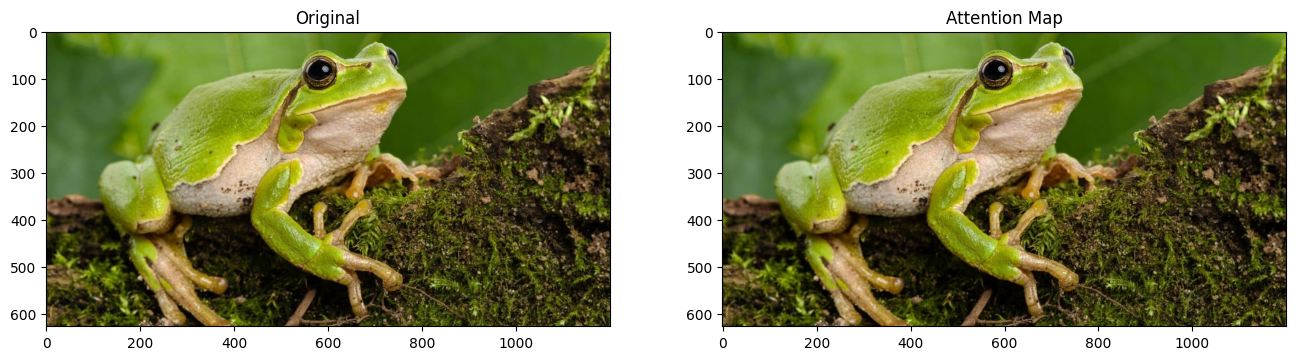

In [226]:
show_attention_map(bit_model2, img)